# chapter03 线性神经网络
## chapter 3.1 线性回归

### 矢量化加速

In [4]:
import math
import time
import numpy as np
import torch

In [5]:
n=10000
a=torch.ones(n)
b=torch.ones(n)

In [8]:
# timer banchmark
# saver
class Timer:
    '''记录多次运行的时间'''
    def __init__(self) -> None:
        self.times=[]
        self.start()
    
    def start(self):
        '''启动定时器'''
        self.tik=time.time()
    def stop(self):
        '''停止计时并记录在列表中'''
        self.times.append(time.time()-self.tik)
        return self.times[-1]
    def avg(self):
        '''return average time'''
        return sum(self.times)/len(self.times)
    def sum(self):
        '''return sum of the time'''
        return sum(self.times)
    def cumsum(self):
        '''返回累积时间'''
        return np.array(self.times).cumsum().tolist()

c=torch.zeros(n)
timer=Timer()
for i in range(n):
    c[i]=a[i]+b[i]
print('未使用矢量化')
print('{}sec'.format(str(timer.stop())))
timer.start()
d=a+b
print('使用矢量化')
print('{}sec'.format(str(timer.stop())))

未使用矢量化
0.17622089385986328sec
使用矢量化
0.0002923011779785156sec


### 线性回归复杂实现

In [12]:
# 第一步，生成包含随机噪音的数据
import random
import torch
def synthetic_data(w,b,num_examples):
    '''生成包含随机噪音的线性回归数据'''
    X=torch.normal(0,1,(num_examples,len(w)))
    y=torch.matmul(X,w)+b
    y+=torch.normal(0,0.01,y.shape)
    return X,y.reshape(-1,1)

true_w=torch.tensor([2,-3.4])
true_b=4.2
features,labels=synthetic_data(true_w,true_b,1000)

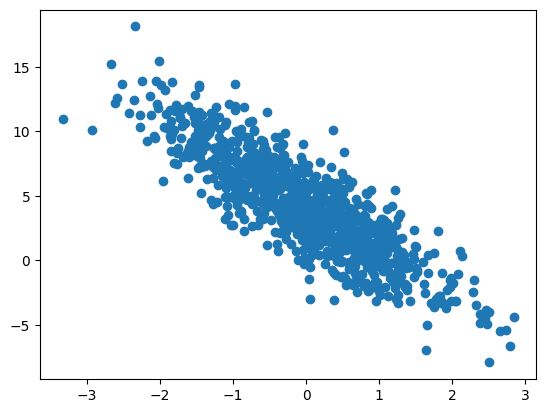

In [13]:
# 第二步，简单的观察feature与labels之间的关系
# 本文中有feature为（1000，2），因此可以看第二个特征和labels之间的关系
import matplotlib.pyplot as plt
plt.scatter(features[:,1],labels)

In [14]:
# 第三部，对数据集进行迭代处理，这样可以保证在随机梯度下降过程中会慢慢转换进去
def data_iter(batch_size,features,labels):
    num_examples=len(features)
    indices=list(range(num_examples))
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        batch_indices=torch.tensor(indices[i:min(i+batch_size,num_examples)])
        yield  features[batch_indices],labels[batch_indices]
# yield的作用这里的迭代的结果是逐步发出来的
batch_size=10
for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break

tensor([[ 2.0665, -0.3741],
        [-1.9531, -1.4392],
        [-0.0920,  0.8410],
        [ 1.1549, -0.4468],
        [ 1.0884, -0.1418],
        [ 0.1041, -0.1451],
        [-1.0249,  0.6740],
        [ 1.2652,  0.4874],
        [-1.1819, -0.0941],
        [ 1.1415,  0.4155]]) 
 tensor([[ 9.6037],
        [ 5.1919],
        [ 1.1507],
        [ 8.0126],
        [ 6.8669],
        [ 4.8779],
        [-0.1496],
        [ 5.0836],
        [ 2.1531],
        [ 5.0608]])


In [15]:
# 第四步，初始化参数
w=torch.normal(0,0.01,size=(2,1),requires_grad=True)
b=torch.zeros(1,requires_grad=True)

In [19]:
# 第五步，定义模型
def linreg(X,w,b):
    '''linear regression'''
    # X M*n
    # w n*1
    return torch.matmul(X,w)+b

In [16]:
# 第六步，定义损失函数
def squared_loss(y_hat,y):
    '''均方误差'''
    return (y_hat-y.reshape(y_hat.shape))**2/2

In [17]:
# 第七步，定义优化算法
def sgd(params,lr,batch_size):
    with torch.no_grad():
        for param in params:
            param-=lr*param.grad/batch_size
            param.grad.zero_()

In [20]:
# 第八步，完整的训练过程
lr=0.03
num_epoch=3
net=linreg
loss=squared_loss

for epoch in range(num_epoch):
    for X,y in data_iter(batch_size,features,labels):
        l=loss(net(X,w,b),y)
        l.sum().backward()
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_l=loss(net(features,w,b),labels)
        print('epoch{},loss{}'.format(str(epoch+1),str(float(train_l.mean()))))


epoch1,loss0.03984002768993378
epoch2,loss0.00013736632536165416
epoch3,loss4.9877315177582204e-05


In [22]:
# 查看估计的参数
b

tensor([4.2002], requires_grad=True)

### 线性回归简洁实现
通过深度学习框架的高级API来实现我们的模型只需要相对较少的代码，我们不必单独分配参数、不必定义我们的损失函数、也不必实现小批量随机梯度下降。当我们需要更复杂的模型的时候，高级API的优势将大大增加

In [27]:
import numpy as np
import torch
from torch.utils import data
# 第一步生成数据集
true_w=torch.tensor([2,-3.4])
true_b=4.2
features,labels=synthetic_data(true_w,true_b,1000)

# 第二步读取数据集
def load_array(data_arrays,batch_size,is_train=True):
    dataset=data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset,batch_size,shuffle=is_train)

batch_size=10
data_iter=load_array((features,labels),batch_size)
# 这里data_iter的方式与之前的方式相似
# 第三步，可视化掠过
# 第四步，定义模型
from torch import nn
net=nn.Sequential(nn.Linear(2,1))
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)

loss=nn.MSELoss()
trainer=torch.optim.SGD(net.parameters(),lr=0.03)

num_epoch=3
for epoch in range(num_epoch):
    for X,y in data_iter:
        l=loss(net(X),y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l=loss(net(features),labels)
    print('epoch{} loss is {}'.format(str(epoch+1),str(float(l))))






epoch1 loss is 0.00018535676645115018
epoch2 loss is 0.0001027520265779458
epoch3 loss is 0.00010297828703187406
